In this notebook, Upsampling with logistic regression is used.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler

# Data Processing

In [2]:
df_train = pd.read_csv("2020_Competition_Training (1).csv")
df_train["train"] = 1
df_test = pd.read_csv("2020_Competition_Holdout .csv")
df_test["train"] = 0
df_test["transportation_issues"] = "NA"
df = pd.concat([df_train, df_test])
df.reset_index(inplace=True)

df.shape #87253 rows with 828 features
#df.drop("person_id_syn", axis=1, inplace=True)
#df= pd.get_dummies(df)
#df.fillna(0,inplace=True)
#df.to_csv("merge_data.csv")

/Users/zixuanzhang/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (80,193) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/zixuanzhang/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (79) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(87253, 828)

In [3]:
df_description = pd.read_excel("final.xlsx")
column_keep = df_description[df_description["Target_col"]==1]["index"].tolist()
column_keep.append("train")
df = df[column_keep]

### Missing Value

In [4]:
df_columns = df.columns.tolist()
df_columns.remove("transportation_issues")
#Columns with missing value
columns_with_missing = []
for column in df_columns:
    if df[column].isnull().sum()>0:
        columns_with_missing.append({"column":column, "missing":df[column].isnull().sum()})
df_missing_distribution = pd.DataFrame.from_dict(columns_with_missing)
df_missing_distribution.sort_values("missing",ascending=False).reset_index(inplace=True)
df_missing_distribution.to_csv("missing_value.csv")
from sklearn.impute import SimpleImputer
# rank 1 blood fat screen or control
# rank 2 data from cons about demos
# rank 3 cms data insurance factor data.
imputer_frequent = SimpleImputer(strategy="most_frequent")
for column in df_missing_distribution["column"]:
    try:
        if df[column].nunique()>=30:
            df[column].fillna(df[column].mean(),inplace=True)
        else:
            df[column].fillna(df[column].value_counts().index[0],inplace=True)
    except:
        print(column)

In [ ]:
#Rethink whether we should get dummies here.
df = pd.get_dummies(df)

### Split the data

In [5]:
df_train = df[df["train"]==1]
df_hold = df[df["train"]==0]

y = df_train["transportation_issues"]
y = y.astype("int")
x = df_train

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [12]:
## Save the features into a csv file
# feature_csv = pd.DataFrame(x_train.columns.tolist())
# feature_csv.to_csv("feature.csv")

# Feature Engineering

## Sampling

### Upsampling

In [7]:
# from sklearn.utils import resample
# X = x_train.copy()
# X["transportation_issues"] = y_train
# # separate minority and majority classes
# wo_tran = X[X["transportation_issues"]==0]
# tran = X[X["transportation_issues"]==1]

# # upsample minority
# tran_upsampled = resample(tran,
#                           replace=True, # sample with replacement
#                           n_samples=len(wo_tran), # match number in majority class
#                           random_state=1) # reproducible results

# upsampled = pd.concat([wo_tran,tran_upsampled])

# # check new class counts
# upsampled["transportation_issues"].value_counts()

# y_train = upsampled["transportation_issues"]
# x_train = upsampled.drop("transportation_issues",axis=1)
# x_train = pd.get_dummies(x_train)

# x_test.drop("transportation_issues",axis=1, inplace=True)
# x_test = pd.get_dummies(x_test)
# x_train,x_test = x_train.align(x_test, join="left", axis=1)

### Down Sampling

In [22]:
from sklearn.utils import resample
X = x_train.copy()
X["transportation_issues"] = y_train
# separate minority and majority classes
wo_tran = X[X["transportation_issues"]==0]
tran = X[X["transportation_issues"]==1]
 
# Downsample majority class
df_majority_downsampled = resample(wo_tran, 
                                 replace=False,    # sample without replacement
                                 n_samples=len(tran),     # to match minority class
                                 random_state=42) # reproducible results
 
# Combine minority class with downsampled majority class
downsampled = pd.concat([df_majority_downsampled, tran])
 
# Display new class counts
downsampled["transportation_issues"].value_counts()

y_train = downsampled["transportation_issues"]
x_train = downsampled.drop("transportation_issues",axis=1)
x_train = pd.get_dummies(x_train)

x_test.drop("transportation_issues",axis=1, inplace=True)
x_test = pd.get_dummies(x_test)
x_train,x_test = x_train.align(x_test, join="left", axis=1)

/Users/zixuanzhang/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


### SMOTE Upsampling

In [23]:
# #This code is not fixed because there are "strings" which SMOTE does not handle.
# #I use SMOTE after the get_dummies, not sure why it throws an error.
# from imblearn.over_sampling import SMOTE 
# smote_sample = SMOTE()

# x_train, y_train = smote_sample.fit_resample(x_train, y_train)

# x_train.drop("transportation_issues",axis=1, inplace=True)
# x_test.drop("transportation_issues",axis=1, inplace=True)
# x_train = pd.get_dummies(x_train) 
# x_test = pd.get_dummies(x_test)
# x_train,x_test = x_train.align(x_test, join="left", axis=1)

## Scaling & Clustering

### Scaler

In [24]:
from sklearn.preprocessing import MinMaxScaler
# Scale the data
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

### PCA

In [25]:
# from sklearn.decomposition import PCA
# #PCA Dimension Reduction
# pca = PCA(n_components=6)
# # prepare transform on dataset
# x_train = pca.fit_transform(x_train)
# x_test[np.isnan(x_test)] = 0 #Fill the na value for logistic regression
# x_test = pca.fit_transform(x_test)

### TSNE

In [26]:
# from sklearn.manifold import TSNE
# x_train = TSNE(n_components=3).fit_transform(x_train) #change the n components.
# x_test[np.isnan(x_test)] = 0 #Fill the na value for logistic regression
# x_test = TSNE(n_components=3).fit_transform(x_test) #change the n components.

## Model

### Logistic Regression

In [27]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(solver = "lbfgs", penalty="l2", random_state=42).fit(x_train, y_train)
y_pred = clf.predict(x_test)

/Users/zixuanzhang/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [28]:
y_prob = clf.predict_proba(x_test)

In [29]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test,y_pred))
(y_test==y_pred).mean() #accuracy 86.87%

#False negative values are larger than the false positive values.

[[12773  5066]
 [ 1102  1931]]


0.7044844768110388

In [30]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_pred)

0.676339420660161

ROC_AUC Score:
0.676339420660161


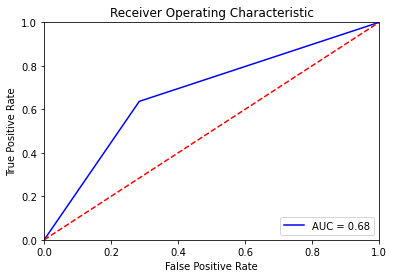

In [31]:
import sklearn.metrics as metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

print("ROC_AUC Score:")
print(roc_auc_score(y_test, y_pred))

#ROC Plot
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()